# FED rate

## load tha data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme, genpareto, bootstrap

# Load dataset
df = pd.read_csv('DFF.csv')

# Choose the desired date range
df = df[(df['observation_date'] >= '1985-01-01') ]

# Convert date column to datetime
df['observation_date'] = pd.to_datetime(df['observation_date'])

# Handle missing values (forward-fill method)
df['DFF'] = df['DFF'].ffill()


## Handle missing values

In [146]:
df['rate_change'] = df['DFF'].pct_change()
df = df.dropna()


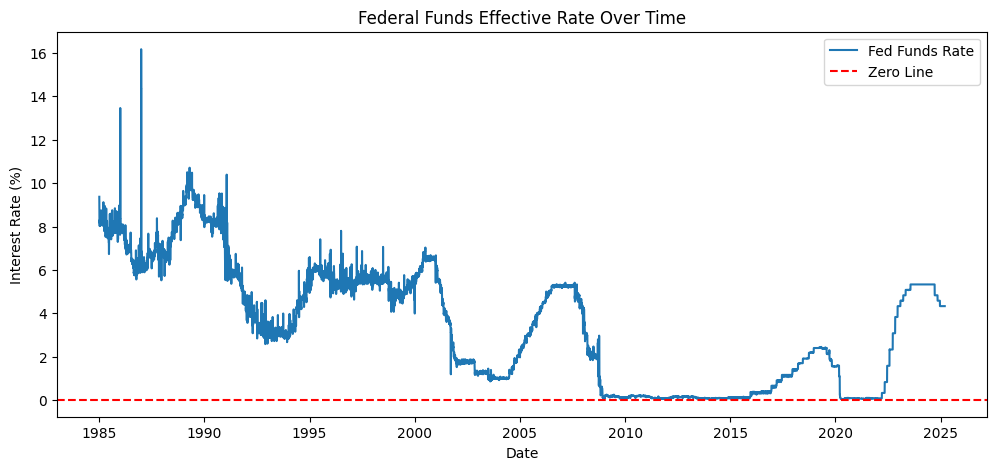

In [147]:
plt.figure(figsize=(12,5))
plt.plot(df['observation_date'], df['DFF'], label='Fed Funds Rate')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Federal Funds Effective Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()


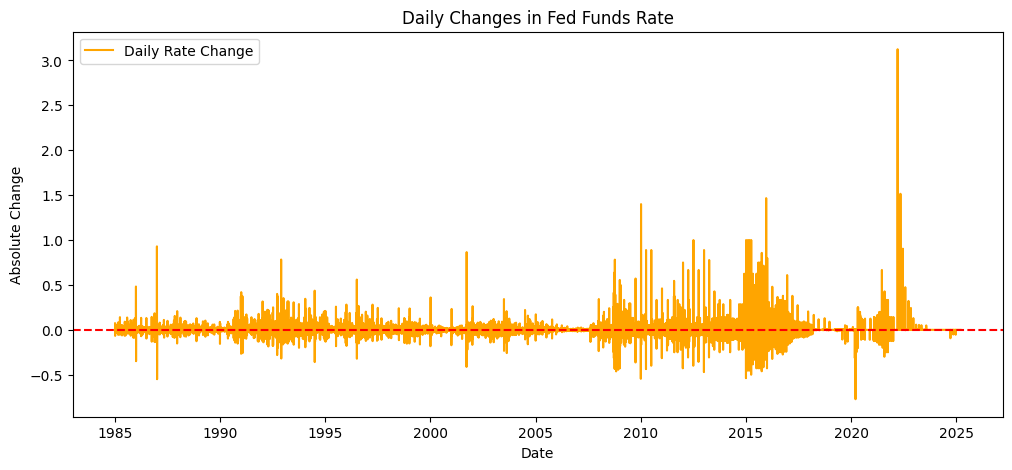

In [148]:
plt.figure(figsize=(12,5))
plt.plot(df['observation_date'], df['rate_change'], label='Daily Rate Change', color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Daily Changes in Fed Funds Rate')
plt.xlabel('Date')
plt.ylabel('Absolute Change')
plt.legend()
plt.show()


In [149]:
# Block Maxima Method for hikes (positive changes)
df['year_month'] = df['observation_date'].dt.to_period('5M')
block_maxima_hikes = df.groupby('year_month')['rate_change'].max()

# Block Minima Method for cuts (negative changes)
block_minima_cuts = df.groupby('year_month')['rate_change'].min()


In [150]:
# Fit GEV Distribution for hikes
gev_params_hikes = genextreme.fit(block_maxima_hikes)
print("GEV Parameters (Hikes - Shape, Location, Scale):", gev_params_hikes)

# Fit GEV Distribution for cuts
gev_params_cuts = genextreme.fit(-block_minima_cuts)  # Negate values to fit correctly
print("GEV Parameters (Cuts - Shape, Location, Scale):", gev_params_cuts)

GEV Parameters (Hikes - Shape, Location, Scale): (np.float64(-0.6319347659479659), np.float64(0.05869126323211672), np.float64(0.06751253759907405))
GEV Parameters (Cuts - Shape, Location, Scale): (np.float64(-0.3756044510615791), np.float64(0.05155081980606331), np.float64(0.054161435752717806))


In [151]:
# Compute 99% Value-at-Risk (VaR) and Expected Shortfall (ES)
var_99_hikes = genextreme.ppf(0.99, *gev_params_hikes)
es_99_hikes = np.mean(block_maxima_hikes[block_maxima_hikes >= var_99_hikes])

var_99_cuts = genextreme.ppf(0.01, *gev_params_cuts)
es_99_cuts = np.mean(block_minima_cuts[block_minima_cuts <= var_99_cuts])

print(f"99% VaR (Hikes): {var_99_hikes:.4f}")
print(f"99% Expected Shortfall (Hikes): {es_99_hikes:.4f}")
print(f"99% VaR (Cuts): {var_99_cuts:.4f}")
print(f"99% Expected Shortfall (Cuts): {es_99_cuts:.4f}")

99% VaR (Hikes): 1.9071
99% Expected Shortfall (Hikes): 3.1250
99% VaR (Cuts): -0.0114
99% Expected Shortfall (Cuts): -0.1252
